In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-02 15:39:53.412946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 15:39:53.433544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730558393.446055 2058174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730558393.449039 2058174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 15:39:53.459659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing Data

In [ ]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)

In [ ]:
train_tx[:,1]
train_ty

array([[11, 28],
       [ 6, 34],
       [ 9, 58],
       ...,
       [ 3, 35],
       [ 0, 34],
       [10, 31]])

Def various functions for labels transformation and common sense error

In [ ]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T

# train_ty_period = periodic_trans(train_ty)
# print(train_ty_period[:10])
# train_ty_period[:,2:]

# y1 = period_to_hrmin(train_ty_period[:,2:],60)
# tt1 = test_ty_period[:3]
# tt2 = train_ty_period[:3]
# train_ty[:10]
# calculate_angle(tt1[:,:2],tt2[:,:2])
# print(common_sense_err(tt1,tt2))

# tt3 = single_angle_trans(train_ty[:3])
# tt4 = single_angle_trans(test_ty[:3])
# sa1 = calculate_angle(tt3,tt4)

# common_sense_err2(train_ty[:3],test_ty[:3])

In [ ]:
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

Model Type 5.1: Multi-head with scaled regression

In [ ]:
K.clear_session()


input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1.summary()
print(model_time_MH1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1 = model_time_MH1.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping, reduce_lr])

I0000 00:00:1730573436.054085 2058174 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30


I0000 00:00:1730573437.996184 2212044 service.cc:148] XLA service 0x723a2c005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730573437.996207 2212044 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-02 19:50:38.039776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730573438.193969 2212044 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-02 19:50:38.328884: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-02 19:50:3

  4/146 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - hr_y_accuracy: 0.1000 - hr_y_loss: 3.1773 - loss: 15.6214 - min_y_loss: 5.9080 - min_y_mae: 2.0126

I0000 00:00:1730573442.429080 2212044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5908 - loss: 8.5860 - min_y_loss: 0.7959 - min_y_mae: 0.5267

2024-11-02 19:50:46.795745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:50:46.874486: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-11-02 19:50:46.885516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 276 bytes spill stores, 276 bytes spill loads

2024-11-02 19:50:47.028160: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1777', 12 bytes spill stores, 12 bytes spill loads

2024-11-02 19:50:47.047806: I external/local_xla/xla/stream_executor/

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5902 - loss: 8.5717 - min_y_loss: 0.7915 - min_y_mae: 0.5252

2024-11-02 19:50:51.298533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 60 bytes spill stores, 60 bytes spill loads

2024-11-02 19:50:51.388389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:50:51.439326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 572 bytes spill stores, 504 bytes spill loads



146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5899 - loss: 8.5647 - min_y_loss: 0.7893 - min_y_mae: 0.5244 - val_hr_y_accuracy: 0.0833 - val_hr_y_loss: 2.4855 - val_loss: 5.1098 - val_min_y_loss: 0.1337 - val_min_y_mae: 0.3018 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0801 - hr_y_loss: 2.4866 - loss: 4.7005 - min_y_loss: 0.0966 - min_y_mae: 0.2622 - val_hr_y_accuracy: 0.0914 - val_hr_y_loss: 2.4842 - val_loss: 3.9736 - val_min_y_loss: 0.1244 - val_min_y_mae: 0.2925 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0916 - hr_y_loss: 2.4866 - loss: 3.7836 - min_y_loss: 0.0852 - min_y_mae: 0.2406 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4864 - val_loss: 3.5053 - val_min_y_loss: 0.1478 - val_min_y_mae: 0.3137 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.1081 - hr_y_loss: 2.4563 - loss: 3.3297 - min_y

2024-11-02 19:53:10.467298: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 244 bytes spill stores, 244 bytes spill loads

2024-11-02 19:53:10.505423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:53:10.554941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 540 bytes spill stores, 604 bytes spill loads

2024-11-02 19:53:11.559538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 248 bytes spill stores, 272 bytes spill loads



57/57 - 2s - 34ms/step - hr_y_accuracy: 0.8756 - hr_y_loss: 0.3335 - loss: 0.5920 - min_y_loss: 0.0295 - min_y_mae: 0.1110


[0.5920030474662781,
 0.3334738314151764,
 0.02953070029616356,
 0.8755555748939514,
 0.11101049929857254]

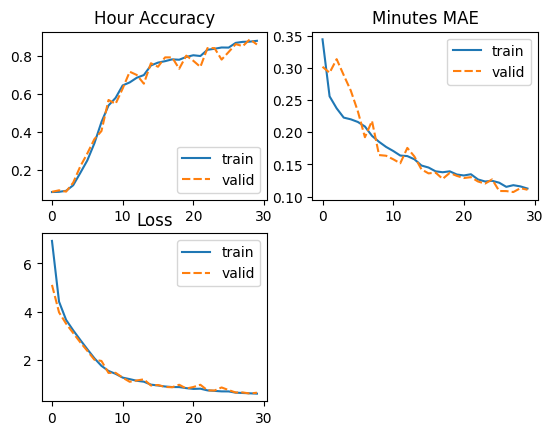

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1.history['loss']
loss_df['valid'] = his_model_time_MH1.history['val_loss']
fig, axs = plt.subplots(ncols=2,nrows=2)
sns.lineplot(hr_acc_df,ax=axs[0,0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[0,1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[1,0]).set_title("Loss")
axs[1, 1].axis('off')
model_time_MH1.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)

In [ ]:
print(test_ty[0:10])
pred_hr_MH1,pred_min_MH1 = model_time_MH1.predict(test_tx)
hr_MH1 = np.argmax(tf.nn.softmax(pred_hr_MH1),axis=1)
min_MH1 = np.round(pred_min_MH1*60).flatten()
hr_MH1[:10],min_MH1[:10]
pred_MH1 = np.array([hr_MH1,min_MH1]).T
pred_MH1
np.mean(common_sense_err2(test_ty,pred_MH1),axis = 0)

[[ 1 42]
 [ 4 59]
 [ 6  8]
 [ 3 38]
 [ 0 29]
 [ 7 50]
 [ 0 34]
 [ 4 50]
 [ 7 39]
 [ 7 44]]
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([0.035     , 9.48222222])

Multi-head with periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2.summary()
print(model_time_MH2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2 = model_time_MH2.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty_period[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,062 (3.35 MB)

 Trainable params: 877,614 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - hr_y_accuracy: 0.0833 - hr_y_loss: 2.5754 - loss: 8.3791 - min_y_loss: 0.8390 - min_y_mae: 0.7411 - val_hr_y_accuracy: 0.0877 - val_hr_y_loss: 2.4958 - val_loss: 4.7100 - val_min_y_loss: 0.5162 - val_min_y_mae: 0.6445 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0817 - hr_y_loss: 2.4860 - loss: 4.2906 - min_y_loss: 0.4728 - min_y_mae: 0.6118 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4854 - val_loss: 3.6739 - val_min_y_loss: 0.4856 - val_min_y_mae: 0.6280 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - hr_y_accuracy: 0.0835 - hr_y_loss: 2.4815 - loss: 3.4261 - min_y_loss: 0.3364 - min_y_mae: 0.4896 - val_hr_y_accuracy: 0.0784 - val_hr_y_loss: 2.4751 - val_loss: 3.3191 - val_min_y_loss: 0.4441 - val_min_y_mae: 0.5905 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accurac

57/57 - 1s - 18ms/step - hr_y_accuracy: 0.8661 - hr_y_loss: 0.3652 - loss: 0.6457 - min_y_loss: 0.0429 - min_y_mae: 0.1492


[0.6457475423812866,
 0.3652147650718689,
 0.042850155383348465,
 0.8661110997200012,
 0.1491561383008957]

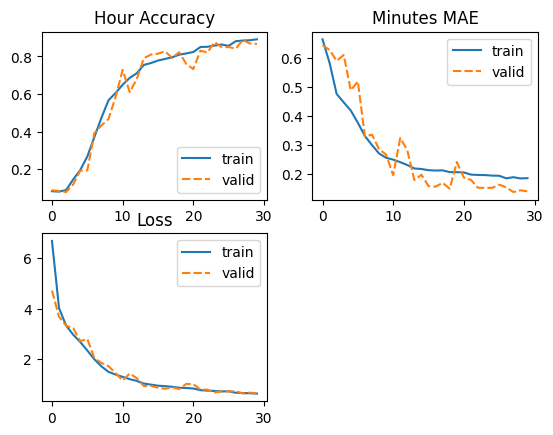

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2.history['loss']
loss_df['valid'] = his_model_time_MH2.history['val_loss']
fig, axs = plt.subplots(ncols=2,nrows=2)
sns.lineplot(hr_acc_df,ax=axs[0,0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[0,1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[1,0]).set_title("Loss")
axs[1, 1].axis('off')
model_time_MH2.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y':test_ty_period[:,2:] }, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_hr_MH2,pred_min_MH2 = model_time_MH2.predict(test_tx)
pred_hr_MH2[:10],pred_min_MH2[:10]
hr_MH2 = np.argmax(tf.nn.softmax(pred_hr_MH2),axis=1)
min_MH2 = period_to_hrmin(pred_min_MH2,60)
hr_MH2[:10],min_MH2[:10]
pred_MH2 = np.array([hr_MH2,min_MH2]).T
print(test_ty[:3],pred_MH2[:3])
np.mean(common_sense_err2(test_ty,pred_MH2),axis = 0)

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 44.]
 [ 5. 57.]
 [ 6.  7.]]


array([0.05722222, 6.29333333])

Single Angle Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1.summary()
print(model_time_P1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1 = model_time_P1.fit(train_tx, single_angle_trans(train_ty),
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 3.3799 - mae: 0.7203 - val_loss: 1.6087 - val_mae: 0.6349 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3679 - mae: 0.6097 - val_loss: 0.9730 - val_mae: 0.6195 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7306 - mae: 0.4609 - val_loss: 0.6978 - val_mae: 0.5807 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4706 - mae: 0.3883 - val_loss: 0.5480 - val_mae: 0.5379 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3223 - mae: 0.3223 - val_loss: 0.3491 - val_mae: 0.4061 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2355 - mae: 0.2772 - val_loss: 0.2506 - val_mae: 0.3248 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1872 - mae: 0.2522 - val_loss: 0.2538 

57/57 - 0s - 2ms/step - loss: 0.0467 - mae: 0.1276


[0.04665307328104973, 0.1276242434978485]

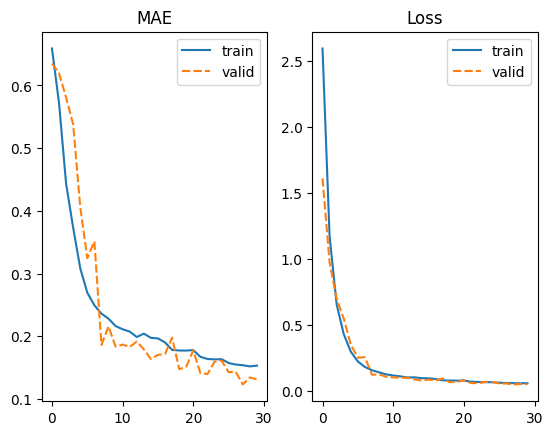

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1.history['mae']
mae_df['valid'] = his_model_time_P1.history['val_mae']
loss_df['train'] = his_model_time_P1.history['loss']
loss_df['valid'] = his_model_time_P1.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1.evaluate(test_tx,  single_angle_trans(test_ty), verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P1 = model_time_P1.predict(test_tx)
pred_P1 = s_ang_to_clk(pred_y_P1)
print(test_ty[:3],pred_P1[:3])
np.mean(common_sense_err2(test_ty,pred_P1),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 37.]
 [ 5. 15.]
 [ 6. 28.]]


array([1.38888889e-02, 1.58538889e+01])

In [ ]:
Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2.summary()
print(model_time_P2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2 = model_time_P2.fit(train_tx, train_ty_period,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,620 (1.78 MB)

 Trainable params: 467,172 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 3.5610 - mae: 0.7521 - val_loss: 1.7831 - val_mae: 0.6379 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.5359 - mae: 0.6108 - val_loss: 1.0925 - val_mae: 0.6228 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8784 - mae: 0.5101 - val_loss: 0.7708 - val_mae: 0.5942 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.6161 - mae: 0.4826 - val_loss: 0.5538 - val_mae: 0.5288 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4925 - mae: 0.4736 - val_loss: 0.4305 - val_mae: 0.4770 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4212 - mae: 0.4628 - val_loss: 0.4144 - val_mae: 0.4959 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3824 - mae: 0.4579 - val_loss: 0.3447 

57/57 - 1s - 12ms/step - loss: 0.0890 - mae: 0.1881


[0.08903136104345322, 0.18809112906455994]

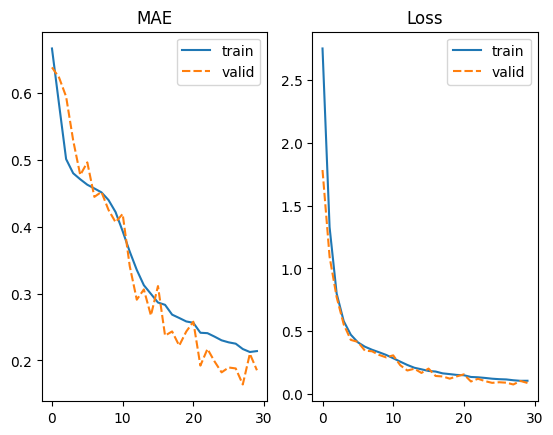

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2.history['mae']
mae_df['valid'] = his_model_time_P2.history['val_mae']
loss_df['train'] = his_model_time_P2.history['loss']
loss_df['valid'] = his_model_time_P2.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2.evaluate(test_tx,  test_ty_period, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P2 = model_time_P2.predict(test_tx)
pred_P2 = period_to_clk(pred_y_P2)
print(test_ty[:3],pred_P2[:3])
np.mean(common_sense_err2(test_ty,pred_P2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[11. 45.]
 [ 5.  1.]
 [ 6.  5.]]


array([ 0.13166667, 12.73888889])

In [ ]:
Dual Regression, scaled minute

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1.summary()
print(model_time_DR1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2 = np.array([train_ty[:,0]/11,train_ty[:,1]/59]).T
his_model_time_DR1 = model_time_DR1.fit(train_tx, train_ty2,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 3.3491 - mae: 0.4600 - val_loss: 1.7001 - val_mae: 0.4942 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.2458 - mae: 0.2574 - val_loss: 1.0123 - val_mae: 0.4461 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7324 - mae: 0.2395 - val_loss: 0.6319 - val_mae: 0.3434 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4908 - mae: 0.2309 - val_loss: 0.4234 - val_mae: 0.2785 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3606 - mae: 0.2282 - val_loss: 0.2938 - val_mae: 0.2224 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2766 - mae: 0.2249 - val_loss: 0.2275 - val_mae: 0.2135 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2213 - mae: 0.2223 - val_loss: 0.1871 

57/57 - 0s - 7ms/step - loss: 0.0669 - mae: 0.1978


[0.06694629788398743, 0.19778777658939362]

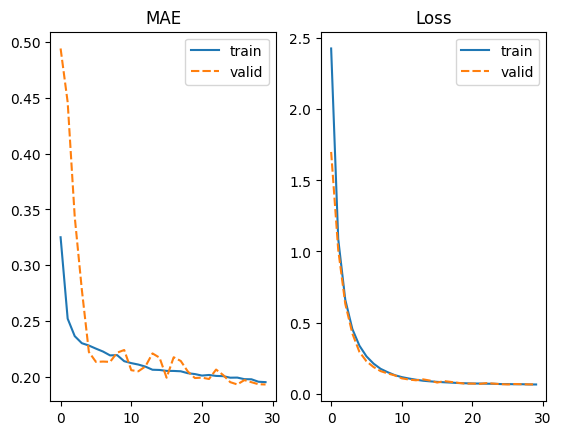

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1.history['mae']
mae_df['valid'] = his_model_time_DR1.history['val_mae']
loss_df['train'] = his_model_time_DR1.history['loss']
loss_df['valid'] = his_model_time_DR1.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
test_ty2 = np.array([test_ty[:,0]/11,test_ty[:,1]/59]).T
model_time_DR1.evaluate(test_tx,  test_ty2, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_DR1 = model_time_DR1.predict(test_tx)
pred_DR1 = np.round(np.array([pred_y_DR1[:,0]*11,pred_y_DR1[:,1]*59]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR1[:3])
np.mean(common_sense_err2(test_ty,pred_DR1),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 6. 29.]
 [ 5. 30.]
 [ 4. 27.]]


array([ 1.43277778, 34.94222222])